In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    csi= confusion_matrix(y_test, pred)[1][1] / (confusion_matrix( y_test, pred)[1][0] + confusion_matrix( y_test, pred)[0][1] + confusion_matrix( y_test, pred)[1][1])  
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, csi:{3:.4f}'.format(accuracy, precision, recall, f1, csi))

In [4]:
train = pd.read_csv('train.csv', encoding='euc_kr')
test = pd.read_csv('test.csv', encoding='euc_kr')

In [5]:
train.columns

Index(['date', 'sd', 'sgg', 'umd', 'aws_sum_rn', 'aws_sum_rn_dur',
       'aws_hr1_max_rn', 'aws_avg_tca', 'aws_avg_ps', 'aws_max_ps',
       'aws_min_ps', 'aws_avg_rhm', 'aws_min_rhm', 'aws_avg_ws', 'aws_max_ws',
       'aws_max_ins_ws', 'asos_sum_rn', 'asos_avg_rhm', 'asos_avg_td',
       'asos_avg_ws', 'diff1', 'diff2', 'diff3', 'diff4', 'diff5', 'diff6',
       'diff7', 'diff8', 'diff9', 'diff10', 'diff11', 'diff12', 'diff13',
       'diff14', 'diff15', 'diff16', 'diff2_1', 'diff2_2', 'diff2_3',
       'diff2_4', 'diff2_5', 'diff2_6', 'diff2_7', 'diff2_8', 'diff2_9',
       'diff2_10', 'diff2_11', 'diff2_12', 'diff2_13', 'diff2_14', 'diff2_15',
       'diff2_16', 'storage_capacity', 'min_infiltration', 'porosity',
       'infiltration', 'humidity_mean', 'humidity_max', 'rn_rn_dur',
       'soil_moisture_mean', 'soil_moisture_min', 'soil_moisure_max',
       'min_ALTT', 'max_ALTT', 'mean_ALTT', 'min_GRDN', 'max_GRDN',
       'mean_GRDN', 'mode_PRRCK_LARG', 'mode_PRRCK_MDDL', 'mode_C

In [6]:
test.columns

Index(['date', 'sd', 'sgg', 'umd', 'aws_sum_rn', 'aws_sum_rn_dur',
       'aws_hr1_max_rn', 'aws_avg_tca', 'aws_avg_ps', 'aws_max_ps',
       'aws_min_ps', 'aws_avg_rhm', 'aws_min_rhm', 'aws_avg_ws', 'aws_max_ws',
       'aws_max_ins_ws', 'asos_sum_rn', 'asos_avg_rhm', 'asos_avg_td',
       'asos_avg_ws', 'diff1', 'diff2', 'diff3', 'diff4', 'diff5', 'diff6',
       'diff7', 'diff8', 'diff9', 'diff10', 'diff11', 'diff12', 'diff13',
       'diff14', 'diff15', 'diff16', 'diff2_1', 'diff2_2', 'diff2_3',
       'diff2_4', 'diff2_5', 'diff2_6', 'diff2_7', 'diff2_8', 'diff2_9',
       'diff2_10', 'diff2_11', 'diff2_12', 'diff2_13', 'diff2_14', 'diff2_15',
       'diff2_16', 'storage_capacity', 'min_infiltration', 'porosity',
       'infiltration', 'humidity_mean', 'humidity_max', 'rn_rn_dur',
       'soil_moisture_mean', 'soil_moisture_min', 'soil_moisure_max',
       'min_ALTT', 'max_ALTT', 'mean_ALTT', 'min_GRDN', 'max_GRDN',
       'mean_GRDN', 'mode_PRRCK_LARG', 'mode_PRRCK_MDDL', 'mode_C

In [7]:
train.shape, test.shape

((583358, 87), (3410, 87))

In [8]:
test[['1day_yn']]=np.nan
test[['2day_yn']]=np.nan

### Outlier Detect

In [9]:
data0=train[(train['1day_yn']==0) & (train['2day_yn']==0)]
data1=train[(train['1day_yn']==1) | (train['2day_yn']==1)]

In [10]:
a=['aws_sum_rn', 'aws_sum_rn_dur',
       'aws_hr1_max_rn', 'aws_avg_tca', 'aws_avg_ps', 'aws_max_ps',
       'aws_min_ps', 'aws_avg_rhm', 'aws_min_rhm', 'aws_avg_ws', 'aws_max_ws',
       'aws_max_ins_ws', 'asos_sum_rn', 'asos_avg_rhm', 'asos_avg_td',
       'asos_avg_ws', 'diff1', 'diff2', 'diff3', 'diff4', 'diff5', 'diff6',
       'diff7', 'diff8', 'diff9', 'diff10', 'diff11', 'diff12', 'diff13',
       'diff14', 'diff15', 'diff16', 'diff2_1', 'diff2_2', 'diff2_3',
       'diff2_4', 'diff2_5', 'diff2_6', 'diff2_7', 'diff2_8', 'diff2_9',
       'diff2_10', 'diff2_11', 'diff2_12', 'diff2_13', 'diff2_14', 'diff2_15',
       'diff2_16', 'storage_capacity', 'min_infiltration', 'porosity',
       'infiltration', 'humidity_mean', 'humidity_max', 'rn_rn_dur',
       'soil_moisture_mean', 'soil_moisture_min', 'soil_moisure_max',
       'min_ALTT', 'max_ALTT', 'mean_ALTT', 'min_GRDN', 'max_GRDN',
       'mean_GRDN']

In [11]:
# Outlier Detect

from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1 
        
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices) 
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n) 
    
    return multiple_outliers

In [12]:
# Outlier로 인해 제거할 행 개수
len(detect_outliers(data0, 25 , a))

3947

In [13]:
outlier_idx=detect_outliers(data0, 25 ,a)
data0_outlier=data0.drop(outlier_idx, axis=0, inplace=False)

In [14]:
train=pd.concat([data0_outlier,data1])

In [15]:
train.shape

(579411, 87)

### Lable Encoding

In [16]:
data_sum = pd.concat([train,test])
data_sum.shape

(582821, 87)

In [17]:
data_sum[['month','mode_PRRCK_LARG', 'mode_PRRCK_MDDL', 'mode_CLZN',
       'mode_TRGRP', 'mode_SLDPT_TPCD', 'mode_FRTP_CD', 'mode_KOFTR_GROU',
       'mode_LDMARK_STN', 'diff_LARG', 'mode_SCSTX', 'mode_SLTP', 'NRCS',
       'soil_group', 'stormday', 'stormday1', 'stormday2']]=data_sum[['month','mode_PRRCK_LARG', 'mode_PRRCK_MDDL', 'mode_CLZN',
       'mode_TRGRP', 'mode_SLDPT_TPCD', 'mode_FRTP_CD', 'mode_KOFTR_GROU',
       'mode_LDMARK_STN', 'diff_LARG', 'mode_SCSTX', 'mode_SLTP', 'NRCS',
       'soil_group', 'stormday', 'stormday1', 'stormday2']].astype('object')

In [18]:
data_sum.shape

(582821, 87)

In [19]:
data_sum = data_sum.iloc[:,4:]

In [20]:
object_columns = data_sum.dtypes[data_sum.dtypes == 'object'].index.tolist()
for column in object_columns:
    data_sum[column] = pd.factorize(data_sum[column])[0]

In [21]:
train = data_sum[~data_sum['1day_yn'].isnull()]
test = data_sum[data_sum['1day_yn'].isnull()]

In [22]:
train.shape , test.shape

((579411, 83), (3410, 83))

In [23]:
test = test.drop(['1day_yn','2day_yn'], axis=1)

In [24]:
train.shape, test.shape

((579411, 83), (3410, 81))

In [25]:
X_24 = pd.concat([train.iloc[:,:32],train.iloc[:,48:81]],axis=1)
X_48 = pd.concat([train.iloc[:,:16],train.iloc[:,32:81]],axis=1)

In [26]:
X_test24 = pd.concat([test.iloc[:,:32],test.iloc[:,48:81]],axis=1)
X_test48 = pd.concat([test.iloc[:,:16],test.iloc[:,32:81]],axis=1)

In [27]:
y_24 = train['1day_yn']
y_48 = train['2day_yn']

### Modeling

In [28]:
X_train24, X_val24, y_train24, y_val24 = train_test_split(X_24, y_24, test_size = 0.2, random_state = 255)
X_train48, X_val48, y_train48, y_val48 = train_test_split(X_48, y_48, test_size = 0.2, random_state = 255)

In [29]:
lgbm24 = LGBMClassifier(
        n_jobs=-1,
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=48,
        subsample=0.65,
        colsample_bytree=0.79,
        max_depth=7,
        silent=-1,
        verbose=-1
        )

lgbm24.fit(X_train24, y_train24, eval_set=[(X_train24, y_train24), (X_val24, y_val24)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 100)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.998435	training's binary_logloss: 0.0021588	valid_1's auc: 0.996698	valid_1's binary_logloss: 0.00185331
[200]	training's auc: 0.999114	training's binary_logloss: 0.00154232	valid_1's auc: 0.997245	valid_1's binary_logloss: 0.00146759
[300]	training's auc: 0.999391	training's binary_logloss: 0.00127895	valid_1's auc: 0.997317	valid_1's binary_logloss: 0.00133893
[400]	training's auc: 0.999569	training's binary_logloss: 0.00111144	valid_1's auc: 0.997732	valid_1's binary_logloss: 0.00127347
[500]	training's auc: 0.999675	training's binary_logloss: 0.00099051	valid_1's auc: 0.997987	valid_1's binary_logloss: 0.00123769
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.999675	training's binary_logloss: 0.00099051	valid_1's auc: 0.997987	valid_1's binary_logloss: 0.00123769


LGBMClassifier(colsample_bytree=0.79, learning_rate=0.01, max_bin=351,
               max_depth=7, min_child_samples=109, min_child_weight=4,
               n_estimators=500, num_leaves=48, reg_alpha=1.15, reg_lambda=3.67,
               silent=-1, subsample=0.65, verbose=-1)

In [30]:
lgbm48 = LGBMClassifier(
        n_jobs=-1,
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=32,
        subsample=0.8,
        colsample_bytree=1,
        max_depth=7,
        silent=-1,
        verbose=-1
        )

lgbm48.fit(X_train48, y_train48, eval_set=[(X_train48, y_train48), (X_val48, y_val48)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 100)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.999896	training's binary_logloss: 0.00100047	valid_1's auc: 0.998306	valid_1's binary_logloss: 0.00178626
Early stopping, best iteration is:
[39]	training's auc: 0.998012	training's binary_logloss: 0.00156866	valid_1's auc: 0.998378	valid_1's binary_logloss: 0.00211535


LGBMClassifier(colsample_bytree=1, learning_rate=0.01, max_depth=7,
               n_estimators=500, num_leaves=32, silent=-1, subsample=0.8,
               verbose=-1)

In [31]:
y_pred24=lgbm24.predict(X_val24)
y_pred48=lgbm48.predict(X_val48)

In [32]:
get_clf_eval(y_val24 , y_pred24)

오차 행렬
[[115816      9]
 [    36     22]]
정확도: 0.9996, 정밀도: 0.7097, 재현율: 0.3793, F1:0.4944, csi:0.4944


In [33]:
get_clf_eval(y_val48 , y_pred48)

오차 행렬
[[115811     13]
 [    42     17]]
정확도: 0.9995, 정밀도: 0.5667, 재현율: 0.2881, F1:0.3820, csi:0.3820


### Feature Importance

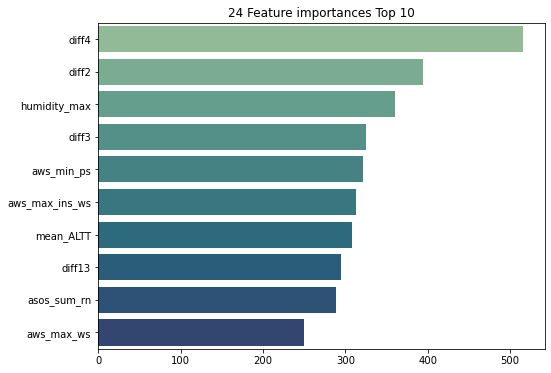

In [34]:
ftr_importances_values = lgbm24.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train24.columns)
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('24 Feature importances Top 10')
sns.barplot(x=ftr_top10 , y = ftr_top10.index, palette="crest")
plt.show()

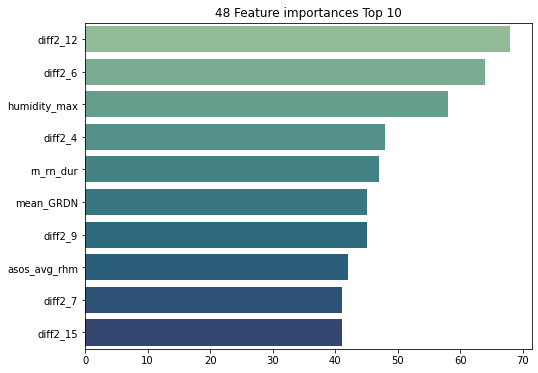

In [35]:
ftr_importances_values = lgbm48.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train48.columns)
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('48 Feature importances Top 10')
sns.barplot(x=ftr_top10 , y = ftr_top10.index, palette="crest")
plt.show()

### Predict

In [36]:
a=pd.DataFrame(data=lgbm24.predict_proba(X_test24)[:,1],columns={'prob24'})
pred1=np.where(a['prob24'] >= 0.0017, 1, 0)
pred1.sum()

64

In [37]:
b=pd.DataFrame(data=lgbm48.predict_proba(X_test48)[:,1],columns={'prob48'})
pred2=np.where(b['prob48'] >=0.0018, 1, 0)
pred2.sum()

142

In [38]:
result=pd.DataFrame({'1day_yn':pred1, '2day_yn':pred2})
result.head() #1일뒤,2일뒤 산사태여부 예측값

,1day_yn,2day_yn
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [39]:
final=pd.read_csv('검증셋.csv',encoding='euc_kr') #제출할 검증셋 불러오기
final['1day_yn']=result['1day_yn']
final['2day_yn']=result['2day_yn']
final.to_csv('210124.csv',encoding='euc_kr',index=False) #제출본 완성